# Salford Dataset - First Look

In [2]:
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
from IPython.display import display

%load_ext autoreload
%autoreload 1
%aimport salford_datasets.salford, salford_datasets.salford_raw, salford_datasets.icd10, salford_datasets.ccs, salford_datasets.salford_raw
from salford_datasets.salford import SalfordData, SalfordFeatures
from salford_datasets.salford_raw import SalfordTimeseries
from salford_datasets.icd10 import ICD10Table
from salford_datasets.ccs import CCSTable

class Notebook:
    DATA_DIR = 'data/Salford'
    FROM_EXCEL = False
    RE_DERIVE = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We load the raw dataset. We can extract the data from the original .xlsx files, but this takes ~20 minutes. We prefer to load the pre-extracted dataframe.

In [3]:
def load_salford_from_excel():
    infiles = [f'{Notebook.DATA_DIR}/v2/part1.xlsx', f'{Notebook.DATA_DIR}/v2/part2.xlsx']
    xlsx = [pd.read_excel(_) for _ in infiles]
    df = pd.concat(xlsx)
    df.to_hdf(f'{Notebook.DATA_DIR}/raw_v2.h5', 'table')
    return df

if Notebook.FROM_EXCEL:
    sal_raw = load_salford_from_excel()
else:
    sal_raw = pd.read_hdf(f'{Notebook.DATA_DIR}/raw_v2.h5', 'table')

We load the raw dataframe into a SalfordData instance. Calling `from_raw` also performs the basic pre-processing steps for us. Calling `augment_derive_all` augments the dataset with some composite features, such as critical care and mortality outcomes or identifying readmissions.

In [ ]:
if Notebook.RE_DERIVE:
    sal = SalfordData.from_raw(sal_raw).augment_derive_all()
    sal.to_hdf(f'{Notebook.DATA_DIR}/sal_processed.h5', 'table')
else:
    sal = SalfordData(pd.read_hdf(f'{Notebook.DATA_DIR}/sal_processed.h5', 'table'))

## Data Availability
We inspect the data availability of the timeseries features.

In [8]:
timeseries_availability = (pd.DataFrame([(
        feature.split('_')[0],
        feature.split('_')[1],
        sal[cols[0]].notna().sum(),
        sal[cols[1]].notna().sum(),
        sal[cols[2]].notna().sum(),
        sal[cols[3]].notna().sum()
    ) for feature, cols in SalfordTimeseries.items()],
    columns=['Group', 'Feature', 'Admission', '24H Post-Adm', '24H Pre-Disch', 'Discharge']
).set_index(['Group', 'Feature'])/sal.shape[0]*100).round(2)
timeseries_availability.loc[['Obs', 'NEWS', 'Blood', 'VBG']]

Admission  24H Post-Adm  24H Pre-Disch  Discharge
Group Feature                                                           
Obs   RespiratoryRate      75.15         49.40          52.19      75.76
      BreathingDevice      75.02         49.32          52.15      75.69
      O2Sats               75.20         49.39          52.20      75.76
      Temperature          75.20         49.40          52.20      75.77
      SystolicBP           75.19         49.38          52.19      75.74
      DiastolicBP          75.15         49.36          52.17      75.71
      HeartRate            75.21         49.39          52.20      75.77
      AVCPU                75.20         49.40          52.20      75.77
      Pain                 71.98         48.97          51.73      74.52
      Nausea              100.00        100.00         100.00     100.00
      Vomiting            100.00        100.00         100.00     100.00
NEWS  Score                75.22         49.40          52.21      75.78
      RespiratoryRate      70.88         46.89          49.47      71.66
      BreathingDevice      70.88         46.89          49.47      71.66
      O2Sat                70.88         46.89          49.47      71.66
      Temperature          70.88         46.89          49.47      71.66
      BP                   70.88         46.89          49.47      71.66
      HeartRate            70.88         46.89          49.47      71.66
      AVCPU                70.88         46.89          49.47      71.66
Blood Haemoglobin          82.12         13.85           3.83      41.01
      Urea                 81.01         15.15           4.71      43.03
      Sodium               81.00         15.85           5.02      44.31
      Potassium            71.46         15.37           5.01      44.28
      Creatinine           80.98         15.51           6.39      68.40
      DDimer                5.85          0.00           0.00       0.44
      CRP                  68.00          8.11           2.19      32.69
      Albumin              69.50         11.19           3.25      38.36
      WhiteCount           82.12         13.85           3.83      41.00
VBG   Temperature           6.99          0.05           0.03       1.38
      pCO2                  6.98          0.05           0.03       1.36
      pCO2                  6.98          0.05           0.03       1.36
      PH                    6.98          0.05           0.03       1.36
      PH                    6.98          0.05           0.03       1.35
      O2                    6.97          0.05           0.03       1.36
      O2                    6.97          0.05           0.03       1.36

In [12]:
# print(timeseries_availability.to_latex(escape=False, index=True, multirow=True, formatters=[
#     lambda x: f'${x:.2f}\%$' for _ in range(4)
# ]))

We do the same across all features.

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print((sal.notna().sum(axis=0)/sal.shape[0]*100))#.apply(lambda x: f'${x:.2f}\%$'))

PatientNumber                       100.000000
Female                              100.000000
Age                                 100.000000
Ethnicity                            99.659145
AE_PresentingComplaint               45.641324
AE_Arrival                           66.909274
AE_Departure                         66.909274
AE_Location                          66.691032
AE_PatientGroup                      66.909274
AE_TriageNote                        66.550341
AdmissionDate                       100.000000
DischargeDate                       100.000000
ElectiveAdmission                   100.000000
AdmitMethod                         100.000000
AdmissionSpecialty                  100.000000
DischargeConsultant                 100.000000
DischargeSpecialty                  100.000000
TotalLOS                            100.000000
LOSBand                             100.000000
AdmitWard                            99.829179
AdmitWardLOS                         99.999738
NextWard2    

## Key Characteristics

In [38]:
sal.AdmitMethod.value_counts().index

Index(['EMERGENCY A+E', 'BOOKED ADMISSION', 'WAITING LIST',
       'EMERGENCY GP REFER', 'EMERG TRAN OTH PROV', 'ELECTIVE PLANNED',
       'NON EM TRAN OTH PROV', 'EMERGENCY OPD', 'MATERNITY ANTE NATAL',
       'TRAUMA ELECTIVE ADM'],
      dtype='object')

In [89]:
def get_key_characteristics_table(df):
    admit_news = {
        'Low (0-4)': (df.NEWS_Score_Admission <= 4).sum(),
        'Medium (5-6)': ((df.NEWS_Score_Admission >= 5) & (df.NEWS_Score_Admission <= 6)).sum(),
        'High (\geq 7)': (df.NEWS_Score_Admission >= 7).sum()
    }
    mortality = {
        'During Stay': df.DiedDuringStay.sum(),
        '30 Days Post-Disch.': df.DiedWithin30Days.sum()
    }
    critical_care = {
        'Total': df.derive_critical_care(ignore_admit_ward=False, within=None, return_series=True).sum(),
        'Post-Admission': df.derive_critical_care(within=None, return_series=True).sum(),
        'Within 24h (Post-Adm.)': df.derive_critical_care(return_series=True).sum(),
    }
    readm = df.derive_readmission_band(bins=[0, 1, 7, 30], labels=['24h', '7d', '30d'])
    readmission = {
        '24 Hours': df.derive_readmission(within=1, return_series=True).sum(),
        '7 Days': df.derive_readmission(within=7, return_series=True).sum(),
        '30 Days': df.derive_readmission(within=30, return_series=True).sum(),
    }

    params = {
        'Population': {'': df.shape[0]},
        'Sex': {'Female': df.Female.sum()},
        'Admission Ward': df.AdmitWard.value_counts().loc[['EAU', 'AEC', 'CCU']].to_dict(),
        'Admission Method': df.AdmitMethod.value_counts().loc[['EMERGENCY A+E', 'BOOKED ADMISSION']].to_dict(),
        'News at Admission': admit_news,
        'Mortality': mortality,
        'Critical Care': critical_care,
        'Readmission': readmission
    }
    result = pd.DataFrame([dict(
        Parameter=parameter,
        Category=category,
        n=value
    ) for parameter, subdict in params.items() for category, value in subdict.items()]).set_index(['Parameter', 'Category'])

    result['\%'] = (result['n']/df.shape[0]*100).round(2)

    return params


key_characteristics = get_key_characteristics_table(sal)
key_characteristics

n      \%
Parameter         Category                              
Population                                381687  100.00
Sex               Female                  201555   52.81
Admission Ward    EAU                     104316   27.33
                  AEC                      37071    9.71
                  CCU                       5661    1.48
Admission Method  EMERGENCY A+E           258539   67.74
                  BOOKED ADMISSION         46161   12.09
News at Admission Low (0-4)               272073   71.28
                  Medium (5-6)              9523    2.49
                  High (>= 7)               5494    1.44
Mortality         During Stay              12171    3.19
                  30 Days Post-Disch.       8397    2.20
Critical Care     Total                    17650    4.62
                  Post-Admission           13876    3.64
                  Within 24h (Post-Adm.)    7801    2.04
Readmission       24h                       3992    1.05
                  7 Days                   19168    5.02
                  30 Days                  55800   14.62

In [80]:
# print(key_characteristics.to_latex(escape=False, index=True, multirow=True, formatters = [
#     lambda x: f'${x}$',
#     lambda x: f'${x}\%$'
# ]))

## ICD-10 Groupings

We fuzzily match the recorded ICD-10 coded diagnoses with the standard lookup table. Some limited losses occur.

In [12]:
icd = ICD10Table.fuzzy_match(sal.Diagnoses)
print(f'Values that we lost due to ICD-10 matching: {sal.Diagnoses.notna().values.sum() - icd.notna().values.sum()} out of {sal.Diagnoses.notna().values.sum()}')

Values that we lost due to ICD-10 matching: 1018 out of 3134818


We may then conver this standardised format into [CCS](https://ibis.health.utah.gov/ibisph-view/pdf/resource/CCS.pdf) diagnosis groups.

In [11]:
ccs = CCSTable.fuzzy_match(icd)
print(f'Values that we lost due to CCS matching: {ccs.notna().values.sum() - icd.notna().values.sum()}')

Values that we lost due to CCS matching: 0


These are then easy to convert to more compact formats, like the HSMR aggregate groups.

In [14]:
# Group from scratch using the SalfordData method
# Use clean_icd10=True to perform the ICD-10 matching before converting to CCS and subsequently HSMR
sal.derive_ccs(return_df=True, clean_icd10=True, grouping='HSMR').sample(5).reset_index(drop=True)

,MainICD10,SecDiag1,SecDiag2,SecDiag3,SecDiag4,SecDiag5,SecDiag6,SecDiag7,SecDiag8,SecDiag9,SecDiag10,SecDiag11,SecDiag12,SecDiag13,SecDiag14,SecDiag15
0,17.0,7.0,7.0,17.0,6.0,7.0,7.0,6.0,5.0,12.0,17.0,17.0,17.0,NaN,NaN,NaN
1,8.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,7.0,10.0,7.0,7.0,8.0,7.0,3.0,9.0,3.0,17.0,17.0,17.0,17.0,17.0,NaN
3,6.0,6.0,7.0,7.0,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,17.0,8.0,8.0,8.0,7.0,9.0,7.0,6.0,17.0,17.0,17.0,NaN,NaN,NaN,NaN


## Laboratory Result String Values

In [20]:
for group, cols in SalfordTimeseries.items():
    ser = sal[cols].stack().rename(group)
    counts = ser[ser.apply(lambda x: isinstance(x, str))].value_counts()
    if counts.shape[0] > 0:
        print(counts)

<1.8      3624
>107.0       1
>53.6        1
Name: Blood_Urea, dtype: int64
<100    11
>200     7
<80      2
>180     2
Name: Blood_Sodium, dtype: int64
>10.0    17
<1.5      1
Name: Blood_Potassium, dtype: int64
<18      1254
>2210       1
Name: Blood_Creatinine, dtype: int64
<150      7763
<21         17
<100         1
>69000       1
Name: Blood_DDimer, dtype: int64
<4.0    104276
<0.5      1546
Name: Blood_CRP, dtype: int64
<10    18
Name: Blood_Albumin, dtype: int64
<0.8    16
Name: VBG_O2, dtype: int64


## Overlap with SCI dataset

In [13]:
from acd_experiment.sci import SCIData, SCICols

scii = (
    SCIData(
        SCIData.quickload("data/SCI/sci_processed.h5").sort_values(
            "AdmissionDateTime"
        )
    )
    .mandate(SCICols.news_data_raw)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(return_subcols=True, within=1)
    .set_index('SpellSerial')
)
sci_sal_intersect = np.intersect1d(sal.index, scii.index)

Common entries: 120704/121279 = 99.53% overlap.
Overlap is 120704/401452 = 30.07% of Salford data.


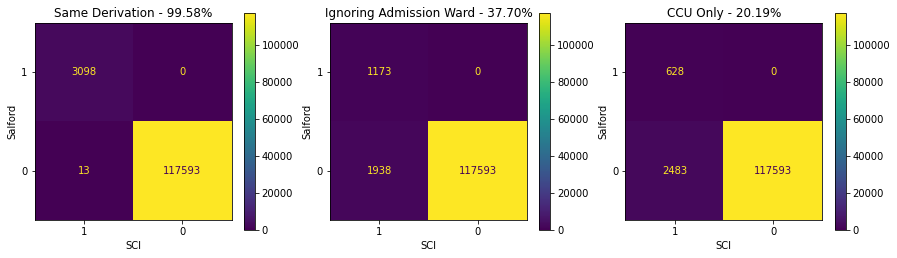

In [46]:
from acd_experiment.utils.salford_dataset_replication import plot_confusion_matrix
print(f'Common entries: {sci_sal_intersect.shape[0]}/{scii.shape[0]} = {sci_sal_intersect.shape[0]/scii.shape[0]*100:.2f}% overlap.')
print(f'Overlap is {sci_sal_intersect.shape[0]}/{sal.shape[0]} = {sci_sal_intersect.shape[0]/sal.shape[0]*100:.2f}% of Salford data.')

def compare_labels(sal, scii):
    salford_labels = {
        'Same Derivation': sal.derive_critical_event(wards=["CCU", "HH1M"], ignore_admit_ward=False, return_series=True),
        'Ignoring Admission Ward': sal.derive_critical_event(wards=["CCU", "HH1M"], return_series=True),
        'CCU Only': sal.derive_critical_event(wards=["CCU"], ignore_admit_ward=True, return_series=True)
    }

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for i, (title, y_sal) in enumerate(salford_labels.items()):
        y_scii, y_sal = scii.CriticalEvent.loc[sci_sal_intersect], y_sal.loc[sci_sal_intersect]
        title = f'{title} - {(y_scii & y_sal).sum()/y_scii.sum()*100:.2f}%'
        plot_confusion_matrix(y_scii, y_sal, ax=ax[i], plot_title=title, normalize=None, xlabel='SCI', ylabel='Salford')

compare_labels(sal, scii)


## Alternative Outcome: SDEC Sense-Checking

We use the dataset to verify the correctness of allocating/not allocating a given patient to SDEC.

Possibilities:
 - Allocated to SDEC:
    - Good: Timely discharge ($\leq$ 12h/24h) AND no readmission 
    - Bad: Admission to ward afterwards OR readmission within 24h/48h/72h
 - No SDEC:
    - "Good": Lengthy stay (LOS $\geq$ 12h/24h)
    - Bad: Shorter stay AND no readmission


In [3]:
from acd_experiment.utils.salford_dataset_replication import plot_confusion_matrix


In [43]:
short_term_readmissions = sal.derive_readmission(within=2, return_series=True)

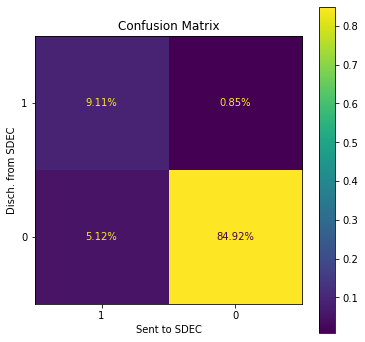

In [15]:
sdec_wards = ["AEC", "AAA"]
plot_confusion_matrix(sal.AdmitWard.isin(sdec_wards), sal.DischargeWard.isin(sdec_wards), xlabel='Sent to SDEC', ylabel='Disch. from SDEC', normalize='all')

In [46]:
subset_idx = sal[sal.SentToSDEC].index
X = sal.loc[subset_idx]
y_true = short_term_readmissions.loc[subset_idx] | ~(X.NextWard2.isin(['AAAC', np.nan]))

In [64]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, fbeta_score, make_scorer

calibration_parameters = dict(
    ensemble=True,
    cv=3,
    method='isotonic',
    n_jobs=3
)

cross_validation_metrics = dict(
    Precision='precision',
    Recall='recall',
    AUC='roc_auc',
    AP='average_precision',
    F2=make_scorer(fbeta_score, beta=2)
)

In [101]:
scores_with_notes_labs_and_hospital = ['NEWS_RespiratoryRate_Admission', 'NEWS_O2Sat_Admission', 'NEWS_Temperature_Admission', 'NEWS_BP_Admission', 'NEWS_HeartRate_Admission', 'NEWS_AVCPU_Admission', 'NEWS_BreathingDevice_Admission', 'Female', 'Age', 'Blood_Haemoglobin_Admission', 'Blood_Urea_Admission', 'Blood_Sodium_Admission', 'Blood_Potassium_Admission', 'Blood_Creatinine_Admission', 'AE_PresentingComplaint', 'AE_MainDiagnosis', 'Readmission', 'AdmitMethod', 'AdmissionSpecialty']
new_features = ['Blood_DDimer_Admission', 'Blood_CRP_Admission', 'Blood_Albumin_Admission', 'Blood_WhiteCount_Admission', 'Waterlow_Score', 'CFS_Score', 'CharlsonIndex']
columns = scores_with_notes_labs_and_hospital + new_features
    
X = SalfordData(sal.loc[subset_idx, columns].sample(frac=1)).convert_str_to_categorical(inplace=False)
y_true = y_true.loc[X.index]
y_true = (~(sal.NextWard2.isin(['AAAC', np.nan]))).loc[X.index]

In [99]:
from lightgbm import LGBMClassifier
lightgbm_parameters = dict(
    objective='binary',
    random_state=42,
    metrics=['l2', 'auc'],
    boosting_type='gbdt',
    n_jobs=1,
    is_unbalance=True
)

r = pd.DataFrame.from_dict(cross_validate(CalibratedClassifierCV(
    LGBMClassifier(**lightgbm_parameters), **calibration_parameters
), X, y_true, cv=5, n_jobs=1, scoring=cross_validation_metrics))

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33)

In [107]:
model = LGBMClassifier(**lightgbm_parameters).fit(X_train, y_train)

,AE_PresentingComplaint,AE_MainDiagnosis,AdmitMethod,AdmissionSpecialty
SpellSerial,,,,
761020_9,26,7,3,0
1893291_24,-1,-1,3,1
1319110_22,28,-1,3,20
2041905_4,14,0,3,0
2028576_2,13,9,3,1
...,...,...,...,...
116485_91,-1,-1,4,1
124117_66,8,-1,3,0
199483_93,26,7,3,0


In [117]:
X_test[X_test.select_dtypes('category').columns] = X_test.select_dtypes('category').apply(lambda x:x.cat.codes)

Text(0.5, 1.0, 'LightGBM')

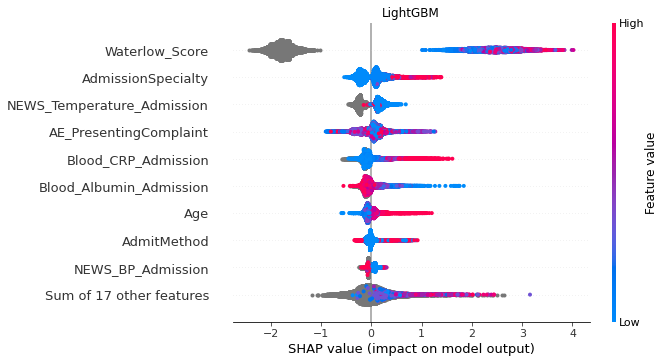

In [118]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=25, show=False
)
plt.title("LightGBM")